In [1]:
import pandas as pd
import numpy as np

happiness = pd.read_excel('../data/happiness/happiness_2022.xls')
hdi = pd.read_excel('../data/happiness/hdi.xlsx')

In [2]:
print(hdi.columns)
hdi = hdi[hdi['indicatorCode'] == 'hdi']
hdi_df = hdi[['countryIsoCode', 'value', 'year']]
hdi_df = hdi_df.rename(columns={'countryIsoCode': 'ISO_A3', 'value': 'HDI', 'year': 'Year'})

print(hdi_df.head())

Index(['countryIsoCode', 'country', 'indexCode', 'index', 'dimension',
       'indicatorCode', 'indicator', 'year', 'value', 'note'],
      dtype='object')
   ISO_A3    HDI  Year
66    AFG  0.284  1990
67    AFG  0.292  1991
68    AFG  0.299  1992
69    AFG  0.307  1993
70    AFG  0.300  1994


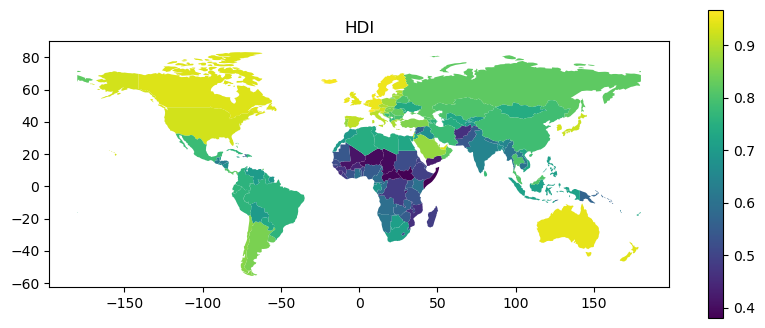

In [3]:
from GeoPlotter import GeoPlotter
gp = GeoPlotter(hdi_df)
gp.plot('HDI', '2022')

/home/jcdutoit/Documents/ACME/Vol3/Vol3FallProj/Joseph_workspace/DataPipeline.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ISO_A3'] = df['Country'].apply(get_country_code)


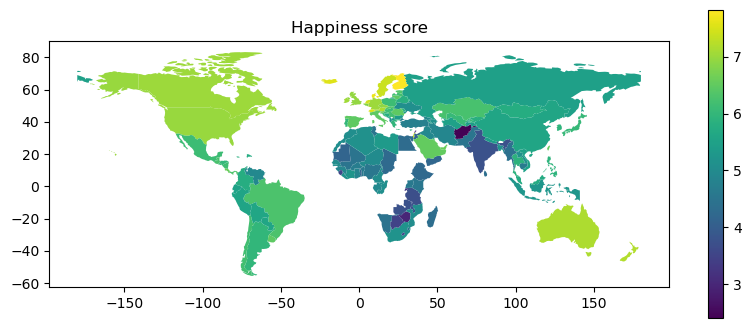

In [4]:
from DataPipeline import DataPipeline
hap_df = happiness[['Country', 'Happiness score']]

dp = DataPipeline(df=hap_df)
dp.clean(['name_change'])
gp2 = GeoPlotter(hap_df)
gp2.plot('Happiness score')


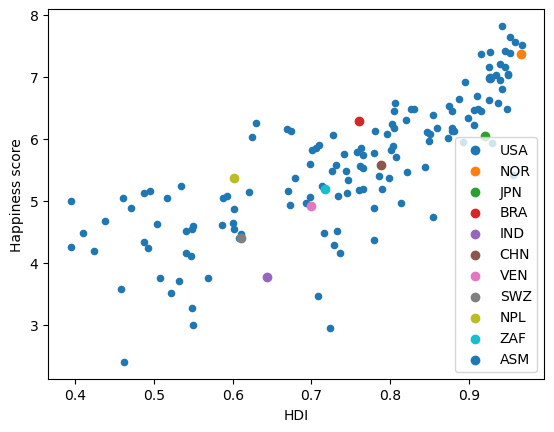

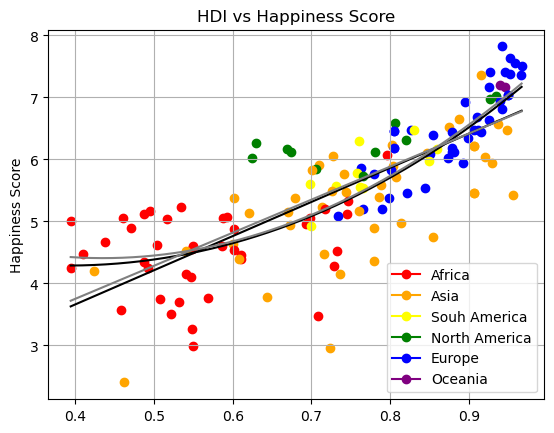

In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pycountry
import pycountry_convert
from scipy.optimize import minimize

hdi_trunc = hdi_df[hdi_df['Year'] == 2022]
hdi_trunc = hdi_trunc.drop(columns=['Year'])

hdi_trunc = hdi_trunc[hdi_trunc['ISO_A3'].isin(hap_df['ISO_A3'])]
merged = pd.merge(hap_df, hdi_trunc, on='ISO_A3')

x = merged['HDI']
y = merged['Happiness score']

model1 = np.polyfit(merged['HDI'], merged['Happiness score'], 1)
model2 = np.polyfit(merged['HDI'], merged['Happiness score'], 3)


cost = lambda b: np.linalg.norm(np.polyval(b, x) - y, 1)
model3_params = minimize(cost, [1, 1]).x
model4_params = minimize(cost, [1, 1, 1]).x

merged.plot.scatter(x='HDI', y='Happiness score')
xs = np.linspace(hdi_trunc['HDI'].min(), hdi_trunc['HDI'].max(), 1000)

plt.xlabel('HDI')

for country in ['USA', 'NOR', 'JPN', 'BRA', 'IND', 'CHN', 'VEN', 'SWZ', 'NPL', 'ZAF', 'ASM']:
    plt.scatter(hdi_trunc.loc[hdi_trunc['ISO_A3'] == country, 'HDI'], hap_df.loc[hap_df['ISO_A3'] == country, 'Happiness score'], label=country)
plt.legend()
plt.show()

colors = {'EU': 'blue', 'AS': 'orange', 'AF': 'red', 'NA': 'green', 'SA': 'yellow', 'OC': 'purple'}

for country in merged['ISO_A3']:
    color = colors[pycountry_convert.country_alpha2_to_continent_code(pycountry.countries.get(alpha_3=country).alpha_2)]
    plt.scatter(merged.loc[merged['ISO_A3'] == country, 'HDI'], merged.loc[merged['ISO_A3'] == country, 'Happiness score'], color=color)

plt.plot(xs, np.polyval(model1, xs), color='black')
plt.plot(xs, np.polyval(model2, xs), color='black')

plt.plot(xs, np.polyval(model3_params, xs), color='gray')
plt.plot(xs, np.polyval(model4_params, xs), color='gray')
plt.ylabel('Happiness Score')
plt.title('HDI vs Happiness Score')

custom_points = [Line2D([0], [0], color='red', marker='o', label='Africa'),
                 Line2D([0], [0], color='orange', marker='o', label='Asia'),
                 Line2D([0], [0], color='yellow', marker='o', label='Souh America'),
                    Line2D([0], [0], color='green', marker='o', label='North America'),
                    Line2D([0], [0], color='blue', marker='o', label='Europe'),
                    Line2D([0], [0], color='purple', marker='o', label='Oceania')]
                 
plt.legend(handles=custom_points, loc="lower right")
plt.grid()
plt.show()


In [6]:
hap_df.to_csv('../data/happiness/happiness.csv', index=False)